<a href="https://colab.research.google.com/github/ricardoV94/stats/blob/master/RL_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a simple Reinforcement Learning model to behavioral data with PyMC3

Reinforcement Learning models are commonly used in behavioral research to model how animals and humans learn, in situtions were they get to make repeated choices that are followed by some form of feedback, such as a reward or a punishment.

In this notebook we will consider the simplest learning scenario, where there are only two possible actions. When an action is taken, it is always followed by an immediate reward. Finally, the outcome of each action is indepent from the previous actions taken. This scenario is sometimes referred to as the [multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit).


Let's say that the two actions (e.g., left and right buttons) are associated with a unit reward 40% and 60% of the time, respectively. At the beginning the learning agent does not know which action $a$ is better, so they may start by assuming both actions have a mean value of 50%. We can store these values in a table, which is usually referred to as a $Q$ table:

$$ Q = \begin{cases}
      .5, a = \text{left}\\
      .5, a = \text{right}
    \end{cases}
$$

When an action is chosen and a reward $r = \{0,1\}$ is observed, the estimated value of that action is updated as follows:

$$Q_{a} = Q_{a} + \alpha (r - Q_{a})$$

where $\alpha$ is a learning parameter that influences how much the value of an action is shifted towards the observed reward in each trial. Finally, the $Q$ table values are converted into action probabilities via the softmax transformation:

$$ P(a = \text{right}) = \frac{\exp(\beta Q_{\text{right}})}{\exp(\beta Q_{\text{right}}) + \exp(\beta Q_{\text{left}})}$$

where the $\beta$ parameter determines the level of noise in the agent choices. Larger positive values will be associated with more deterministic choices and larger negative values with increasingly random choices.


In [0]:
%%capture
!pip install arviz==0.6.1

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

In [0]:
sns.set(font_scale=1.5)
np.random.seed(632020)

## Generating fake data

In [0]:
def generate_data(alpha, beta, n=100, p_r=[.4, .6]):
    actions = np.zeros(n, dtype=np.int)
    rewards = np.zeros(n, dtype=np.int)
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([.5, .5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta*Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = np.random.choice([0, 1], p=prob_a)
        r = np.random.rand() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(20,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)

    s = 50
    lw = 2

    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    plt.scatter(0, 20, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20, 20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    plt.yticks([0,1], ['left', 'right'])
    plt.ylim(-1, 2)

    plt.ylabel('action')
    plt.xlabel('trial')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]

    plt.legend(handles, labels, fontsize=12, loc=(1.01, .27))
    plt.tight_layout()

In [0]:
true_alpha = .5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(true_alpha, true_beta, n)

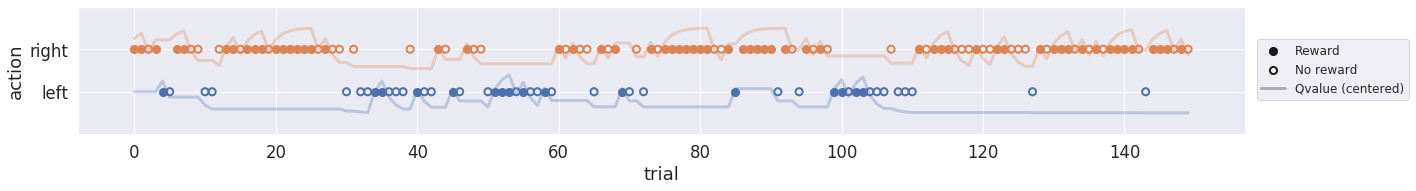

In [6]:
plot_data(actions, rewards, Qs)

The plot above shows a simulated run of 150 trials, with parameters $\alpha = .5$ and $\beta = 5$, and constant reward probabilities of $.4$ and $.6$ for the left (blue) and right (orange) actions, respectively. 

Filled and empty dots indicate actions followed by rewards and no-rewards, respectively. The solid line shows the estimated $Q$ value for each action centered around the respective colored dots (the line is above its dots when the respective $Q$ value is above $.5$, and below otherwise). It can be seen that this value increases with rewards (solid dots) and decreases with non-rewards (empty dots). 

The change in line height following each outcome is directly related to the $\alpha$ pamater. The influence of the $\beta$ parameter is more difficult to grasp, but one way to think about it is that the higher it's value, the higher the probability of flipping between actions regardless of their estimated values. 

We can also see that value of the unchosen action is not altered by the outcome of the chosen action. This is a strong assumption of this model, which could be tested by comparing it to an alternative model where this is not the case.

## Estimating the learning parameters via Maximum Likelihood

Having generated the data, the goal is to now 'invert the model' to estimate the learning parameters $\alpha$ and $\beta$. I start by doing it via Maximum Likelihood Estimation (MLE). This requires writing a custom function that computes the likelihood of the data given a potential alpha and beta and the fixed observed actions and rewards (actually the function computes the negative log likelihood, in order to avoid undeflow issues).

I employ the handy scipy.optimize.minimize function, to quickly retrieve the values of alpha and beta that maximize the likelihood of the data (or actually, minimize the negative log likelihood).

This was also helpful for when I later wrote the theano function that computed the choice probabilities in PyMC3. First, the underlying logic is the same, the only thing that changes is the syntax. Second, it provides a way to be confident that I did not screw up, and what I was actually computing was what I intended to.



In [0]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([.5, .5])
    log_prob_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions,rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])

The function `llik_td` is strikingly similar to the `generate_data` one, except that instead of simulating an action and reward in each trial, it stores the log-probability of the observed action.

The function `scipy.special.logsumexp` is used to compute the term $\log(\exp(\beta Q_{\text{right}}) + \exp(\beta Q_{\text{left}}))$ in a way that is more numerically stable. 

In the end, the function returns the negative sum off all the log probabilities,which is equivalent to multiplying the probabilities in their original scale.

(The first action is ignored just to make the output comparable to the later theano function. It doesn't actually change any estimation, as the initial probabilities are fixed and do not depend on either the $\alpha$ or $\beta$ parameters.)

In [8]:
llik_td([true_alpha, true_beta], *(actions, rewards))

53.932968370963074

Above, I computed the negative log likelihood of the data given the true $\alpha$ and $\beta$ parameters.

Below, I let scipy find the MLE values for the two parameters:

In [9]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})')
print(f'MLE: beta = {result.x[1]:.2f} (true value = {true_beta})')

      fun: 53.19822741509421
 hess_inv: array([[ 0.00682533, -0.01550099],
       [-0.01550099,  0.97845405]])
      jac: array([-9.53674316e-07, -4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.55820985, 5.76679102])

MLE: alpha = 0.56 (true value = 0.5)
MLE: beta = 5.77 (true value = 5)


The estimated MLE values are relatively close to the true ones. However, this procedure does not give any idea of the plausible uncertainty around these parameters values. To get that, I'll turn to PyMC for a bayesian posterior estimation.

But before that, I will implement a simple vectorization optimization to the log-likelihood function that will be more similar to the theano counterpart. The reason for this is to speedup the slow bayesian inference engine down the road.

In [0]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype=np.float)
    Qs[0] = .5
    for t, (a, r) in enumerate(zip(actions[:-1], rewards[:-1])):  # The last Q values were never used, so there is no need to compute them
        Qs[t+1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t+1, 1-a] = Qs[t, 1-a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the log_prob_actions for the observed actions
    log_prob_actions = log_prob_actions[np.arange(len(actions)), actions]
    return -np.sum(log_prob_actions[1:])

In [11]:
llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

53.932968370963074

In [12]:
%timeit llik_td([true_alpha, true_beta], *(actions, rewards))

100 loops, best of 3: 5.8 ms per loop


In [13]:
%timeit llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

1000 loops, best of 3: 748 µs per loop


The vectorized function gives the same results, but runs almost one order of magnitude faster. 

When implemented as a Theano function, the difference between the vectorized and standard version was not this drastic. Still, it ran twice as fast, which meant the model also sampled at twice the speed it would otherwise have!


## Estimating the learning parameters via PyMC

The most challenging part was to create a theano function/loop to estimate the Q values when sampling our parameters with PyMC.

In [0]:
def update_Q(action, reward,
             Qs,
             alpha):

    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [0]:
# Transform the variables into appropriate Theano objects
rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
actions_ = theano.shared(np.asarray(actions, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * tt.ones(2, dtype='float64')

# Compute the Q values for each trial
Qs, updates = theano.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# Apply the softmax transformation
Qs_ = Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]-1), actions_[1:]]
neg_log_like = -tt.sum(log_prob_actions)

Let's wrap it up in a function to test out if it's working as expected.

In [16]:
theano_llik_td = theano.function(inputs=[alpha, beta], outputs=neg_log_like, updates=updates)
result = theano_llik_td(true_alpha, true_beta)
float(result)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


53.932968370963096

The same result is obtained, so we can be confident that the theano loop is working as expected. We are now ready to implement the PyMC model.

In [0]:
def theano_llik_td(alpha, beta, actions, rewards):
    rewards = theano.shared(np.asarray(rewards, dtype='int16'))
    actions = theano.shared(np.asarray(actions, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs_ = Qs[:-1] * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    log_prob_actions = log_prob_actions[tt.arange(actions.shape[0]-1), actions[1:]]
    return tt.sum(log_prob_actions)  # PyMC makes it negative by default

In [18]:
with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.Normal('beta', 0, 10)

    like = pm.Potential('like', theano_llik_td(alpha, beta, actions, rewards))

    tr = pm.sample()

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tens

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5476658eb8>,
      dtype=object)

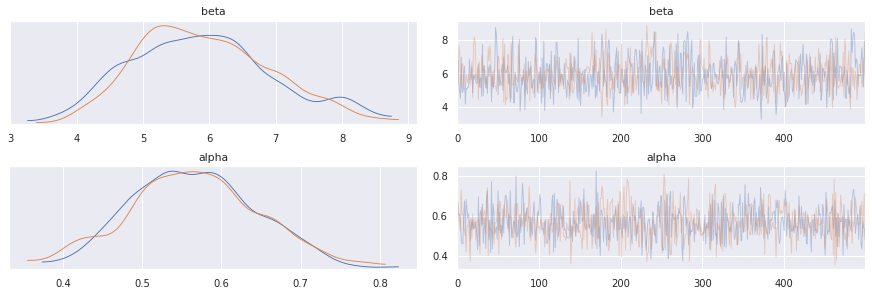

In [19]:
az.plot_trace(tr)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f548fe72c18>,
      dtype=object)

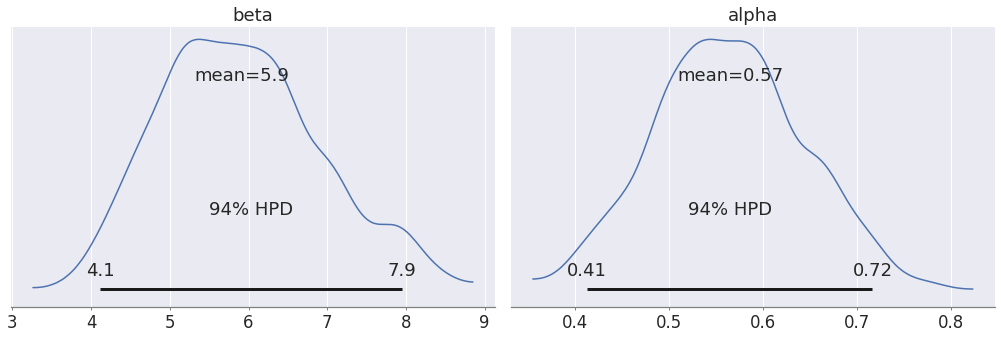

In [20]:
az.plot_posterior(tr)

In this example, the obtained posteriors are nicely centered around the MLE values. What we have gained is an idea of the empirical uncertainty around these values, which was missing from simply computing using MLE.

### Bonus: Alternative model using pm.Bernoulli for the likelihood

In [0]:
def right_action_probs(alpha, beta, actions, rewards):
    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs_ = Qs[:-1] * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Return the probabilities for the right action, in the original scale
    return tt.exp(log_prob_actions[:, 1]) 

In [22]:
with pm.Model() as m_alt:
    rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))

    alpha_ = pm.Beta('alpha', 1, 1)
    beta_ = pm.Normal('beta', 0, 10)

    action_probs = right_action_probs(alpha_, beta_, actions_, rewards_)
    like = pm.Bernoulli('like', p=action_probs, observed=actions_[1:])

    tr_alt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 1000/1000 [00:15<00:00, 66.50it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

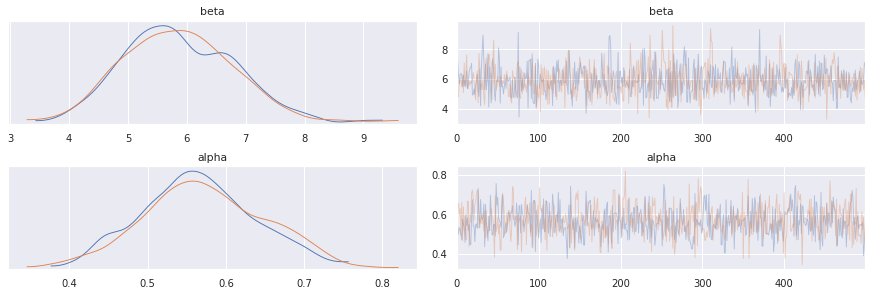

In [23]:
az.plot_trace(tr_alt);